In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 目的：スペインの電力価格を予測
# 目的変数：スペインの電力価格(actual_price)
# 評価指標：RME

import numpy as np
import pandas as pd
import os
import pickle
import gc
# 分布確認
!pip install ydata-profiling
from ydata_profiling import ProfileReport
# 可視化
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl
# 前処理
from sklearn.preprocessing import StandardScaler, MinMaxScaler,LabelEncoder,OneHotEncoder
# モデリング
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from xgboost import XGBClassifier
import lightgbm as lgb
# 日本語表記
!pip install japanize-matplotlib
import japanize_matplotlib
%matplotlib inline
# パラメータ最適化
!pip install optuna
import optuna

# 評価指標
from sklearn.metrics import mean_squared_error

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.1/400.1 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 687.8/687.8 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 3.0 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=f5df09c65cbf6bd72353930ee38de4d6ce46a186986c6751ddc1878b3ba123b0
  Stored in directory: /root/.cache/pip/wheels/8d/55/1a/19cd535375ed1ede0c996405ebffe34b196d78e2d9545723a2
Successfully built htmlmin


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 28.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=4fcdb44453bc87eb9e32376dbbde7ef40a0d7a0f499f919d60d78116d8761510
  Stored in directory: /root/.cache/pip/wheels/da/a1/71/b8faeb93276fed10edffcca20746f1ef6f8d9e071eee8425fc
Successfully built japanize-matplotlib
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 18.7 MB/s eta 0:00:00


In [3]:
file_path = '/content/drive/MyDrive/Colab Notebooks/signate/smbc/'

df_train = pd.read_csv(file_path + 'train.csv')
df_test = pd.read_csv(file_path + 'test.csv')
df_sample = pd.read_csv(file_path + 'sample_submit.csv',header=None)

In [ ]:
print(df_train.shape)
display(df_train.head())
display(df_train.info())

In [ ]:
print(df_test.shape)
display(df_test.head())
display(df_test.info())

In [4]:
# 時刻をdatetimeに変換
df_train["time"] = pd.to_datetime(df_train["time"],utc=True)
df_test["time"] = pd.to_datetime(df_test["time"],utc=True)

# 年情報のカラム作成（クロスバリデーション用）
df_train["year"] = df_train["time"].dt.year
df_test["year"] = df_test["time"].dt.year

# ケルビンを摂氏に変換  - 273.15
cities = ["valencia","madrid","bilbao","barcelona","seville"]
for city in cities:
  df_train[f"{city}_temp"] = df_train[f"{city}_temp"] - 273.15
  df_train[f"{city}_temp_min"] = df_train[f"{city}_temp_min"] - 273.15
  df_train[f"{city}_temp_max"] = df_train[f"{city}_temp_max"] - 273.15




## 特徴量エンジニアリング

In [5]:
# 季節性（spring:1,summer:2,autumn:3,winter:4）
def get_season(month):
    if month in [3, 4, 5]:
        return 1
    elif month in [6, 7, 8]:
        return 2
    elif month in [9, 10, 11]:
        return 3
    else:
        return 4

# 月を取得 → 季節に変換
df_train["month"] = df_train["time"].dt.month
df_train["season"] = df_train["month"].apply(get_season)

# テストデータにも
df_test["month"] = df_test["time"].dt.month
df_test["season"] = df_test["month"].apply(get_season)

In [6]:
# 時間帯（morning:1,afternoon:2,evening:3,night:4）

def get_time_of_day(hour):
    if 5 <= hour < 11:
        return 1
    elif 11 <= hour < 17:
        return 2
    elif 17 <= hour < 21:
        return 3
    else:
        return 4

df_train["hour"] = df_train["time"].dt.hour
df_train["time_of_day"] = df_train["hour"].apply(get_time_of_day)

# テストデータにも
df_test["hour"] = df_test["time"].dt.hour
df_test["time_of_day"] = df_test["hour"].apply(get_time_of_day)

In [7]:
# 週末フラグ

def is_week_end(weekday):
    if weekday in [0,1,2,3,4]:
      return 0
    elif weekday in [0,1,2,3,4]:
      return 1
    else:
      return 2

df_train["weekday"] = df_train["time"].dt.weekday
df_train["is_weekend"] = df_train["weekday"].apply(is_week_end)

# テストデータにも
df_test["weekday"] = df_test["time"].dt.weekday
df_test["is_weekend"] = df_test["weekday"].apply(is_week_end)

## データ分割＆モデル実装

In [ ]:
# カテゴリカルカラムの抜き出し
categorical_cols = [
    col for col in df_train.select_dtypes(include=['object', 'category']).columns
    if col != "price_actual"
    ]
# 数値カラムの抜き出し
numerical_cols = [
    col for col in df_train.select_dtypes(include=['int64', 'float64']).columns
    ]
print('*'*20,'実行結果確認','*'*20,)
print(f'カテゴリ{categorical_cols}')
print(f'数値{numerical_cols}')

******************** 実行結果確認 ********************
カテゴリ['valencia_weather_main', 'valencia_weather_description', 'valencia_weather_icon', 'madrid_weather_main', 'madrid_weather_description', 'madrid_weather_icon', 'bilbao_weather_main', 'bilbao_weather_description', 'bilbao_weather_icon', 'barcelona_weather_main', 'barcelona_weather_description', 'barcelona_weather_icon', 'seville_weather_main', 'seville_weather_description', 'seville_weather_icon']
数値['generation_biomass', 'generation_fossil_brown_coal/lignite', 'generation_fossil_gas', 'generation_fossil_hard_coal', 'generation_fossil_oil', 'generation_hydro_pumped_storage_consumption', 'generation_hydro_run_of_river_and_poundage', 'generation_hydro_water_reservoir', 'generation_nuclear', 'generation_other', 'generation_other_renewable', 'generation_solar', 'generation_waste', 'generation_wind_onshore', 'total_load_actual', 'valencia_temp', 'valencia_temp_min', 'valencia_temp_max', 'valencia_pressure', 'valencia_humidity', 'valencia_wi

In [9]:
# 訓練データ、テストデータ作成（＝目的変数分離）
x_train = df_train[[
    'year',
    'generation_fossil_gas',
    'generation_fossil_hard_coal',
    'generation_fossil_oil',
    'generation_hydro_pumped_storage_consumption',
    'generation_hydro_run_of_river_and_poundage',
    'generation_hydro_water_reservoir',
    'generation_other_renewable',
    'total_load_actual',
    "season",
    "time_of_day",
    "is_weekend",
    ]]
y_train = df_train['price_actual']
x_test = df_test[[
    'generation_fossil_gas',
    'generation_fossil_hard_coal',
    'generation_fossil_oil',
    'generation_hydro_pumped_storage_consumption',
    'generation_hydro_run_of_river_and_poundage',
    'generation_hydro_water_reservoir',
    'generation_other_renewable',
    'total_load_actual',
    "season",
    "time_of_day",
    "is_weekend",
    ]]

In [10]:
# パラメータ
params = {
    'boosting_type':'gbdt',
    'objective':'regression',
    'metric':'rmse',
    'learning_rate':0.1,
    'num_leaves':16,
    'n_estimators':10000,
    'random_state':123,
    'importance_type':'gain'
}

In [11]:
def light_gbm_model_stepwise(input_x, input_y, df_train, df_test, params):


    # ✅ Step-by-step 予測関数（テストデータを1行ずつ予測）
    def step_by_step_predict(df_train, df_test, x_columns, model):
        lag = df_train["price_actual"].iloc[-1]  # ラグの初期値
        preds = []

        for i in range(len(df_test)):
            row = df_test.iloc[i].copy()
            row["price_lag1"] = lag
            row_input = pd.DataFrame([row[x_columns]])
            pred = model.predict(row_input)[0]
            preds.append(pred)
            lag = pred  # ラグを更新

        return np.array(preds)

    # 検証対象年リスト
    valid_years = [2016, 2017]

    # 出力用
    oof = np.zeros(len(input_y))
    preds = np.zeros(len(df_test))
    rmse_list = []

    for i, valid_year in enumerate(valid_years):
        print("#" * 15, f"Fold {i+1}（検証年: {valid_year}）", "#" * 15)

        # 時系列に基づいてインデックス指定
        train_idx = input_x[input_x["year"] < valid_year].index
        valid_idx = input_x[input_x["year"] == valid_year].index

        x_tr = input_x.loc[train_idx].drop(columns="year")
        y_tr = input_y.loc[train_idx]
        x_va = input_x.loc[valid_idx].drop(columns="year")
        y_va = input_y.loc[valid_idx]

        # モデルを訓練
        lgb_model = lgb.LGBMRegressor(**params)
        lgb_model.fit(
            x_tr, y_tr,
            eval_set=[(x_va, y_va)],
            callbacks=[
                lgb.early_stopping(stopping_rounds=50),
                lgb.log_evaluation(period=10)
            ]
        )

        # 検証予測
        y_pred = lgb_model.predict(x_va)
        oof[valid_idx] = y_pred

        # Step-by-stepでテストデータ予測
        step_preds = step_by_step_predict(df_train, df_test, x_tr.columns, lgb_model)
        preds += step_preds

        # RMSE 計算
        mse = mean_squared_error(y_va, y_pred)
        rmse = np.sqrt(mse)
        rmse_list.append(rmse)
        print(f"RMSE: {rmse:.4f}")

    # 平均
    preds /= len(valid_years)

    # 特徴量重要度
    feature_importance = pd.DataFrame({
        'feature': x_tr.columns,
        'importance': lgb_model.feature_importances_,
        'gain': lgb_model.booster_.feature_importance(importance_type='gain')
    })

    return oof, preds, rmse_list, feature_importance

In [12]:
oof, preds, rmse_list, feature_importance = light_gbm_model_stepwise(
    x_train, y_train, df_train, df_test, params
)

############### Fold 1（検証年: 2016） ###############
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003530 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1817
[LightGBM] [Info] Number of data points in the train set: 8737, number of used features: 11
[LightGBM] [Info] Start training from score 61.358245
Training until validation scores don't improve for 50 rounds
[10]	valid_0's rmse: 17.9439
[20]	valid_0's rmse: 17.2714
[30]	valid_0's rmse: 17.0286
[40]	valid_0's rmse: 16.8883
[50]	valid_0's rmse: 16.9598
[60]	valid_0's rmse: 16.9489
[70]	valid_0's rmse: 16.8697
[80]	valid_0's rmse: 16.8784
[90]	valid_0's rmse: 16.9097
[100]	valid_0's rmse: 16.8349
[110]	valid_0's rmse: 16.75
[120]	valid_0's rmse: 16.7715
[130]	valid_0's rmse: 16.7534
[140]	valid_0's rmse: 16.7874
[150]	valid_0's rmse: 16.7895
[160]	valid_0's rmse: 16.7803
[170]	valid_0'

-------------------------------------------------- ✅結果まとめ✅ --------------------------------------------------
平均 RMSE: 14.1998
OOF array shape: (26280,)
Preds array shape: (8760,)


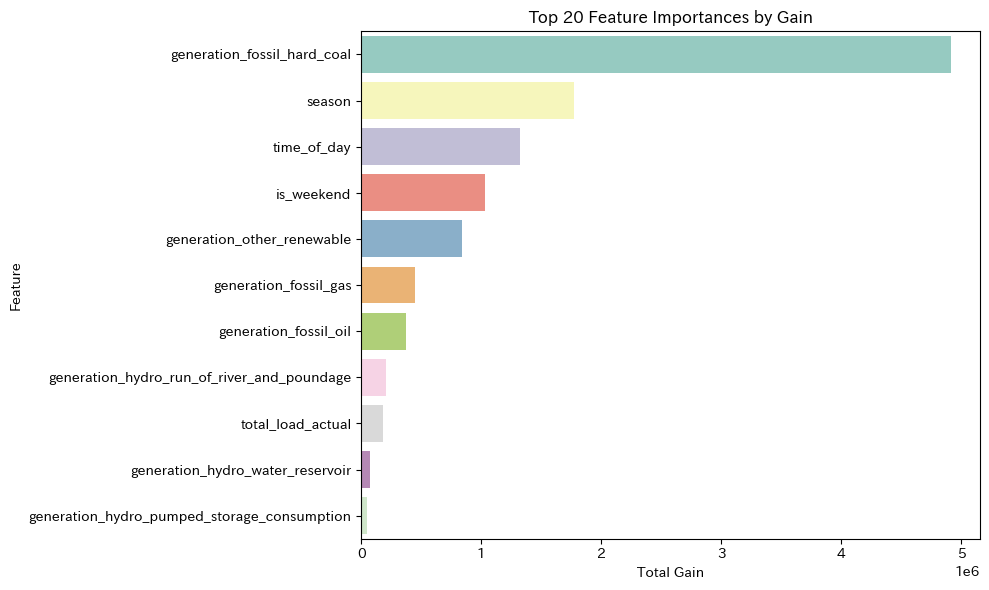

In [13]:

print("-"*50,"✅結果まとめ✅","-"*50,)

print(f'平均 RMSE: {np.mean(rmse_list):.4f}')
print(f'OOF array shape: {oof.shape}')
print(f'Preds array shape: {preds.shape}')

# ソート
feature_importance = feature_importance.sort_values('gain', ascending=False)

# 上位20個をプロット
plt.figure(figsize=(10, 6))
sns.barplot(
    x='gain',
    y='feature',
    hue='feature',
    data=feature_importance.head(20),
    palette='Set3',
    legend=False
    )
plt.title("Top 20 Feature Importances by Gain")
plt.xlabel("Total Gain")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [ ]:
from datetime import date

today = date.today()

df_sub = pd.read_csv(file_path + 'sample_submit.csv',header=None)

submission = pd.DataFrame({
    'time':df_sub.iloc[:, 0] ,
    'pred': preds
})
submission.to_csv(f'submission_{today}.csv', index=False, header=False)
print(f'✅ Submission file saved as submission_{today}.csv')

✅ Submission file saved as submission_2025-06-14.csv
